COVID klasöründeki dosya sayısı: 2
Normal klasöründeki dosya sayısı: 2
Viral Pneumonia klasöründeki dosya sayısı: 2
Lung_Opacity klasöründeki dosya sayısı: 2
Sınıflar: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


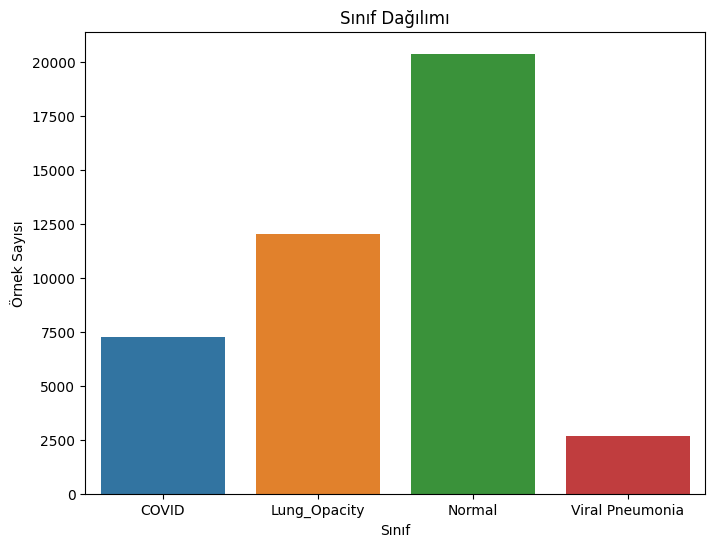

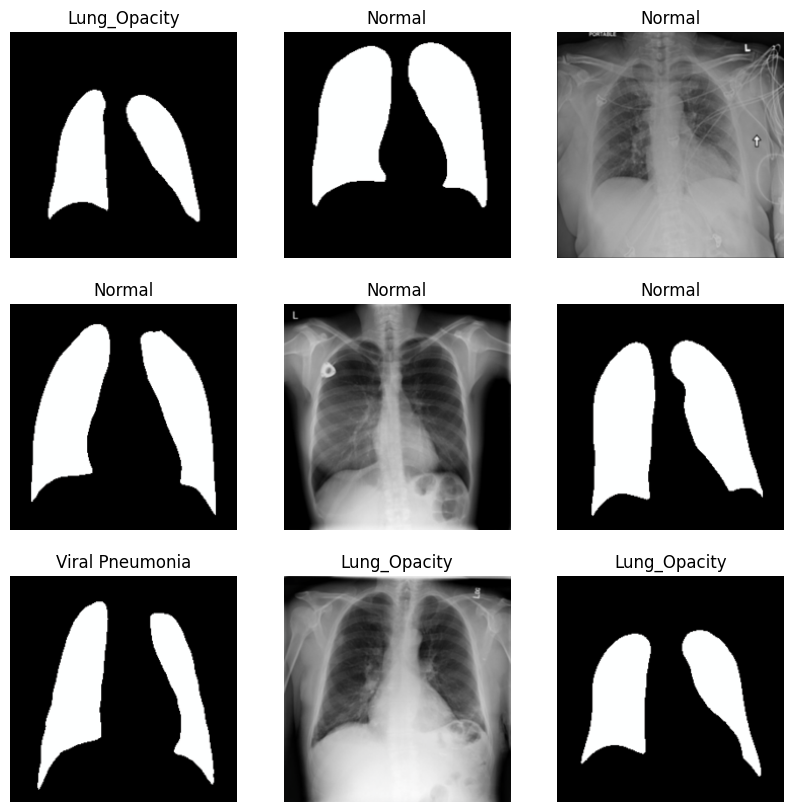


Deneme: LR=0.001, Dropout=0.3, Batch Size=16
Epoch [1/5] Train Loss: 1.1569, Train Acc: 0.4983, Val Loss: 1.0712, Val Acc: 0.5483
Epoch [2/5] Train Loss: 1.0035, Train Acc: 0.5791, Val Loss: 0.9462, Val Acc: 0.6102
Epoch [3/5] Train Loss: 0.9321, Train Acc: 0.6147, Val Loss: 0.8876, Val Acc: 0.6286
Epoch [4/5] Train Loss: 0.8716, Train Acc: 0.6444, Val Loss: 0.8331, Val Acc: 0.6593
Epoch [5/5] Train Loss: 0.8182, Train Acc: 0.6711, Val Loss: 0.7633, Val Acc: 0.7007

Deneme: LR=0.001, Dropout=0.3, Batch Size=32
Epoch [1/5] Train Loss: 1.1772, Train Acc: 0.4892, Val Loss: 1.1284, Val Acc: 0.5286
Epoch [2/5] Train Loss: 1.0527, Train Acc: 0.5548, Val Loss: 0.9708, Val Acc: 0.5870
Epoch [3/5] Train Loss: 0.9412, Train Acc: 0.6107, Val Loss: 0.9089, Val Acc: 0.6420
Epoch [4/5] Train Loss: 0.8878, Train Acc: 0.6389, Val Loss: 0.8408, Val Acc: 0.6625
Epoch [5/5] Train Loss: 0.8443, Train Acc: 0.6586, Val Loss: 0.8428, Val Acc: 0.6614

Deneme: LR=0.001, Dropout=0.5, Batch Size=16
Epoch [1/5] 

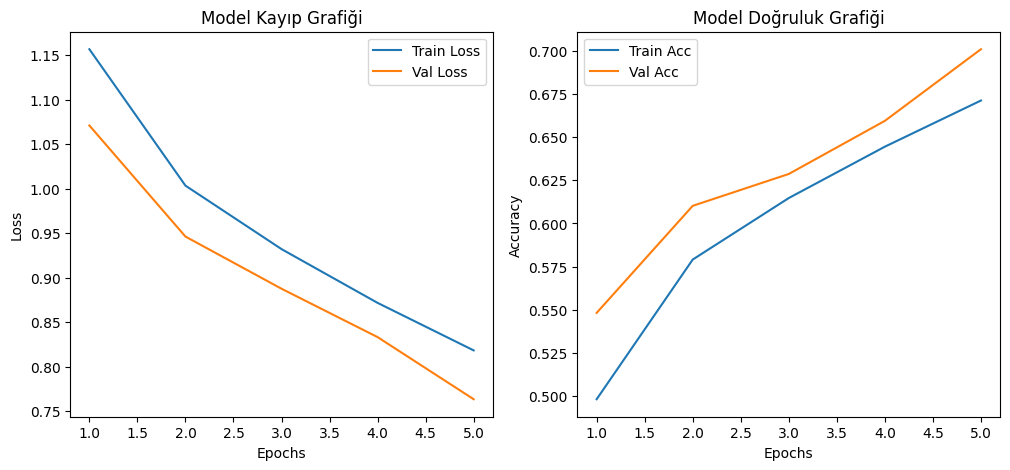

Test Accuracy: 0.7037
Classification Report:
                 precision    recall  f1-score   support

          COVID       0.79      0.27      0.40      1099
   Lung_Opacity       0.66      0.73      0.70      1803
         Normal       0.71      0.85      0.78      3051
Viral Pneumonia       0.76      0.61      0.68       398

       accuracy                           0.70      6351
      macro avg       0.73      0.62      0.64      6351
   weighted avg       0.71      0.70      0.68      6351



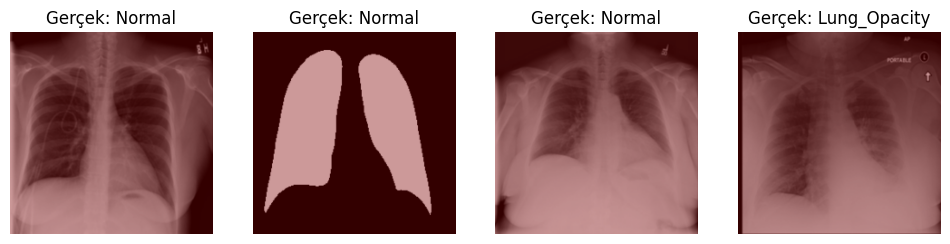


Test Doğruluğu: 0.7037


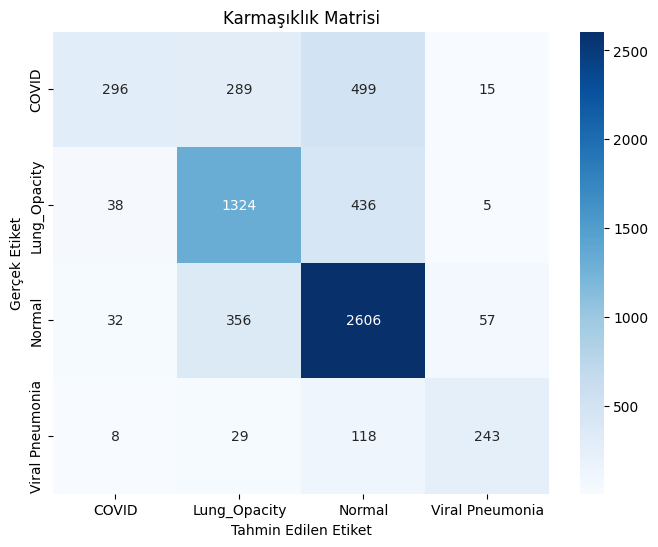

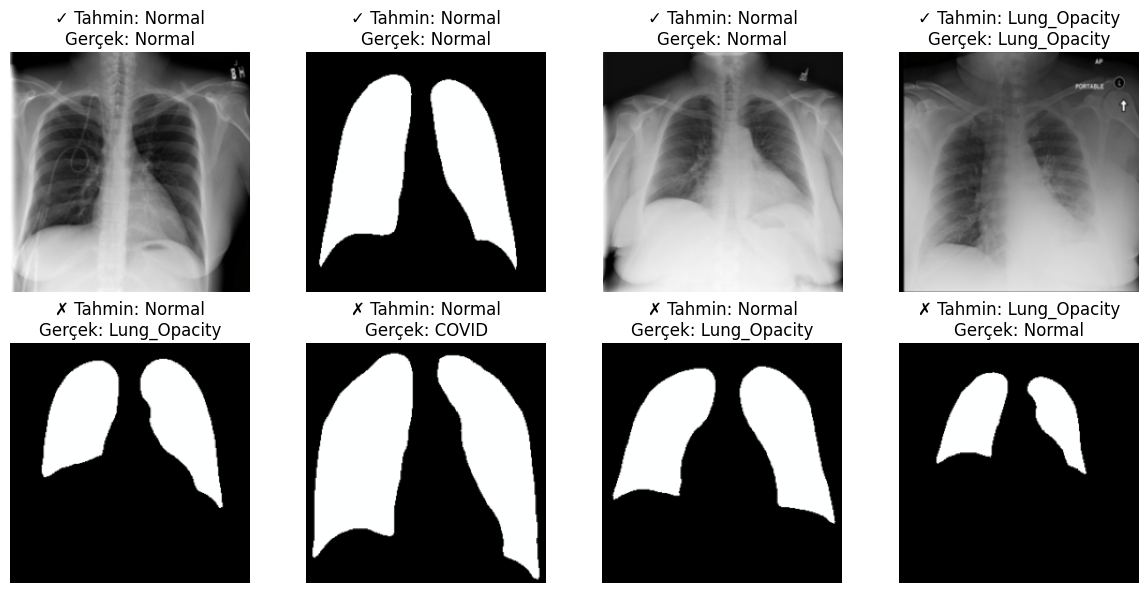

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from itertools import product
import cv2

# =====================
# 1. Dataset Yolu
# =====================
data_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
folders = ["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]
for name in folders:
    folder_path = os.path.join(data_dir, name)
    if os.path.exists(folder_path):
        print(f"{name} klasöründeki dosya sayısı:", len(os.listdir(folder_path)))
    else:
        print(f"Uyarı: {folder_path} bulunamadı!")

# =====================
# 2. Transform + Data Augmentation
# =====================
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =====================
# 3. Dataset Yükleme
# =====================
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
print("Sınıflar:", class_names)

train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

batch_size_default = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size_default, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size_default, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size_default, shuffle=False)

# =====================
# 4. Veri Görselleştirme
# =====================
labels = [class_names[label] for _, label in full_dataset.samples]
plt.figure(figsize=(8,6))
sns.countplot(x=labels, order=class_names)
plt.title("Sınıf Dağılımı")
plt.xlabel("Sınıf")
plt.ylabel("Örnek Sayısı")
plt.show()

dataiter = iter(train_loader)
images, labels_batch = next(dataiter)
fig, axes = plt.subplots(3,3, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = images[i].numpy().transpose((1,2,0))
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0,1)
        ax.imshow(img)
        ax.set_title(class_names[labels_batch[i]])
        ax.axis('off')
plt.show()

# =====================
# 5. Basit CNN Model (AdaptiveAvgPool)
# =====================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128*1*1,256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# =====================
# 6. Accuracy/Loss Grafikleri Fonksiyonu
# =====================
def plot_history(history):
    epochs = range(1,len(history["train_loss"])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Kayıp Grafiği")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Doğruluk Grafiği")
    plt.legend()
    plt.show()

# =====================
# 7. Eğitim Fonksiyonu
# =====================
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0,0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1)==labels).sum().item()

        model.eval()
        val_loss, val_correct = 0.0,0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs,labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1)==labels).sum().item()

        train_loss_epoch = train_loss/len(train_loader.dataset)
        val_loss_epoch   = val_loss/len(val_loader.dataset)
        train_acc_epoch  = train_correct/len(train_loader.dataset)
        val_acc_epoch    = val_correct/len(val_loader.dataset)

        history["train_loss"].append(train_loss_epoch)
        history["val_loss"].append(val_loss_epoch)
        history["train_acc"].append(train_acc_epoch)
        history["val_acc"].append(val_acc_epoch)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss_epoch:.4f}, Train Acc: {train_acc_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")
    return model, history

# =====================
# 8. Grid Search Hiperparametre
# =====================
learning_rates = [0.001, 0.0005]
dropouts = [0.3, 0.5]
batch_sizes = [16, 32]

best_val_acc = 0
best_params = {"lr": None, "dropout": None, "batch_size": None, "history": None, "model": None}

for lr, dr, bs in product(learning_rates, dropouts, batch_sizes):
    print(f"\nDeneme: LR={lr}, Dropout={dr}, Batch Size={bs}")
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=bs, shuffle=False)
    
    model = SimpleCNN(num_classes=len(class_names), dropout_rate=dr)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    model, history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)
    
    val_acc = history["val_acc"][-1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = {"lr": lr, "dropout": dr, "batch_size": bs, "history": history, "model": model}

# Grid search sonrası model yoksa tek model ile eğitim
if best_params["model"] is None:
    print("En iyi model bulunamadı, tek model ile eğitim yapılıyor.")
    model = SimpleCNN(num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)
    best_params["model"] = model
    best_params["history"] = history

print("\nEn iyi parametreler:", {k:v for k,v in best_params.items() if k not in ["history","model"]}, 
      "Val Accuracy:", best_val_acc)

# =====================
# 9. Grafikleri Çiz
# =====================
plot_history(best_params["history"])

# =====================
# 10. Test + Confusion Matrix
# =====================
def evaluate_model(model, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    acc = np.mean(np.array(y_true)==np.array(y_pred))
    print(f"Test Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# =====================
# 11. Grad-CAM Fonksiyonu (düzeltilmiş)
# =====================
def grad_cam(model, image, target_class=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    image = image.to(device)

    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_layer = model.features[-1]  # AdaptiveAvgPool
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    output = model(image)
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    gradient = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]
    weights = np.mean(gradient, axis=(1, 2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i]

    cam = np.maximum(cam, 0)
    if np.max(cam) != 0:   # sıfıra bölmeyi engelle
        cam = cam / np.max(cam)
    cam = np.uint8(cam * 255)

    # Görseli orijinal haline çevir
    image_np = image.cpu().squeeze().numpy().transpose(1, 2, 0)
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)
    image_np = np.uint8(image_np * 255)

    # Eğer tek kanal kaldıysa RGB'ye çevir
    if len(image_np.shape) == 2:  # (H, W)
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    elif image_np.shape[2] == 1:  # (H, W, 1)
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)

    # 🔹 Heatmap boyutunu input ile eşitle
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

    # 🔹 Tip uyumsuzluğu hatasını engelle
    if image_np.dtype != np.uint8:
        image_np = np.uint8(image_np)

    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    handle_forward.remove()
    handle_backward.remove()

    return superimposed_img


# =====================
# 12. Grad-CAM Görselleştirme
# =====================
def show_grad_cam_examples(model, test_loader, class_names, num_examples=4):
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    plt.figure(figsize=(12,3*num_examples))

    for i in range(num_examples):
        img_tensor = images[i].unsqueeze(0)
        cam_image = grad_cam(model, img_tensor)
        plt.subplot(1, num_examples, i+1)
        plt.imshow(cam_image)
        plt.title(f"Gerçek: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()

# =====================
# 13. Test Örnekleri ile Değerlendirme (Doğru/Yanlış Tahminler)
# =====================
def evaluate_with_examples(model, test_loader, class_names, num_examples=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    images_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            images_list.extend(images.cpu())

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"\nTest Doğruluğu: {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Karmaşıklık Matrisi")
    plt.ylabel("Gerçek Etiket")
    plt.xlabel("Tahmin Edilen Etiket")
    plt.show()

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    correct_indices = np.where(y_true == y_pred)[0]
    incorrect_indices = np.where(y_true != y_pred)[0]

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(correct_indices[:num_examples]):
        img = images_list[idx].numpy().transpose((1,2,0))
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0,1)
        plt.subplot(2, num_examples, i+1)
        plt.imshow(img)
        plt.title(f"✓ Tahmin: {class_names[y_pred[idx]]}\nGerçek: {class_names[y_true[idx]]}")
        plt.axis("off")

    for i, idx in enumerate(incorrect_indices[:num_examples]):
        img = images_list[idx].numpy().transpose((1,2,0))
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0,1)
        plt.subplot(2, num_examples, num_examples+i+1)
        plt.imshow(img)
        plt.title(f"✗ Tahmin: {class_names[y_pred[idx]]}\nGerçek: {class_names[y_true[idx]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# =====================
# 14. Test Fonksiyonlarını Çağır
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_params["model"].to(device)

evaluate_model(best_model, test_loader, class_names)
show_grad_cam_examples(best_model, test_loader, class_names)
evaluate_with_examples(best_model, test_loader, class_names)